In [1]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import os

import pyvisa
rm = pyvisa.ResourceManager()
rm.list_resources()

('ASRL3::INSTR',
 'ASRL4::INSTR',
 'ASRL5::INSTR',
 'ASRL6::INSTR',
 'ASRL7::INSTR',
 'ASRL8::INSTR',
 'ASRL11::INSTR',
 'ASRL12::INSTR',
 'ASRL21::INSTR')

In [2]:

# Connect to the Keithley 6487
rm = pyvisa.ResourceManager()
keithley = rm.open_resource("GPIB0::22::INSTR")  # Adjust GPIB address if needed
keithley.write("SOUR:VOLT:RANG 500")  # Set voltage range to 100V max
keithley.write("SOUR:VOLT 67")  # Set voltage to 10V
keithley.write("SOUR:VOLT:STAT ON")  # Turn on voltage source
keithley.query("SOUR:VOLT?")
print(keithley.query("READ?"))
keithley.write("SOUR:VOLT:STAT OFF")



-6.780156E-10A,+7.041992E+01,+5.120000E+02



20

Connecting to Keithley 6487...
Connecting to Arduino...
Sent: SET 5 | Mode: Cooling
Waiting for stabilization at 5°C...
Current Temp: 13.27°C | Target: 5°C | ΔT: 8.27°C
Current Temp: 13.25°C | Target: 5°C | ΔT: 8.25°C
Current Temp: 13.25°C | Target: 5°C | ΔT: 8.25°C
Current Temp: 13.21°C | Target: 5°C | ΔT: 8.21°C
Current Temp: 13.19°C | Target: 5°C | ΔT: 8.19°C
Current Temp: 13.15°C | Target: 5°C | ΔT: 8.15°C
Current Temp: 13.15°C | Target: 5°C | ΔT: 8.15°C
Current Temp: 13.08°C | Target: 5°C | ΔT: 8.08°C
Current Temp: 13.02°C | Target: 5°C | ΔT: 8.02°C
Current Temp: 13.02°C | Target: 5°C | ΔT: 8.02°C
Current Temp: 12.96°C | Target: 5°C | ΔT: 7.96°C
Current Temp: 12.94°C | Target: 5°C | ΔT: 7.94°C
Current Temp: 12.88°C | Target: 5°C | ΔT: 7.88°C
Current Temp: 12.83°C | Target: 5°C | ΔT: 7.83°C
Current Temp: 12.83°C | Target: 5°C | ΔT: 7.83°C
Current Temp: 12.79°C | Target: 5°C | ΔT: 7.79°C
Current Temp: 12.73°C | Target: 5°C | ΔT: 7.73°C
Current Temp: 12.73°C | Target: 5°C | ΔT: 7.73°

SerialException: ClearCommError failed (PermissionError(13, 'Het apparaat herkent de opdracht niet.', None, 22))

In [ ]:
import pyvisa
import serial
import csv
import numpy as np
import time
import os

# ================== CONFIGURATION ==================
GPIB_ADDRESS = "GPIB0::22::INSTR"  # Keithley 6487
ARDUINO_PORT = "COM3"              # Arduino port
BAUD_RATE = 115200
DATA_FOLDER = "IV_data"
TEMP_TOLERANCE = 0.5
STABILIZATION_TIMEOUT = 900  # seconds
NUM_READINGS = 5
DELAY_PER_VOLT = 5

# ================== VOLTAGE SWEEP ==================
voltages = np.concatenate([
    np.arange(55, 62, 1),
    np.arange(62, 66.5, 0.1),
    np.arange(66.5, 74, 0.25)
])

# ================== INITIALIZE DEVICES ==================
print("Connecting to Keithley 6487...")
rm = pyvisa.ResourceManager()
keithley = rm.open_resource(GPIB_ADDRESS)
keithley.timeout = 60000

print("Connecting to Arduino...")
arduino = serial.Serial(ARDUINO_PORT, BAUD_RATE, timeout=3)
time.sleep(2)

# ================== KEITHLEY SETUP ==================
def configure_keithley():
    keithley.write("*RST")
    keithley.write("FUNC 'CURR'")
    keithley.write("SYST:ZCH ON")
    keithley.write("CURR:RANG 2E-9")
    keithley.write("INIT")
    keithley.write("SYST:ZCOR:STAT OFF")
    keithley.write("SYST:ZCOR:ACQ")
    keithley.write("SYST:ZCOR ON")
    keithley.write("CURR:RANG:AUTO ON")
    keithley.write("SYST:ZCH OFF")
    keithley.write("SOUR:VOLT:RANG 500")
    keithley.write("SOUR:VOLT:ILIM 2.5E-3")
    keithley.write("SOUR:VOLT:STAT ON")
    keithley.write("CURR:NPLC 10")
    keithley.write("FORM:ELEM READ")
    time.sleep(2)

# ================== TEMPERATURE CONTROL ==================
def set_temperature(temp, mode="H"):
    arduino.write(f"SET {temp}\n".encode())
    time.sleep(0.2)
    if mode.upper() == "H":
        arduino.write(b"H\n")
    elif mode.upper() == "C":
        arduino.write(b"C\n")
    print(f"Sent: SET {temp} | Mode: {'Heating' if mode == 'H' else 'Cooling'}")

def wait_for_stabilization(target_temp):
    print(f"Waiting for stabilization at {target_temp}°C...")
    start_time = time.time()

    while True:
        line = arduino.readline().decode(errors='ignore').strip()
        if not line.startswith("TEMP"):
            continue
        parts = line.split(",")
        try:
            temp = float(parts[1])
        except (IndexError, ValueError):
            continue

        delta = abs(temp - target_temp)
        print(f"Current Temp: {temp:.2f}°C | Target: {target_temp}°C | ΔT: {delta:.2f}°C")
        if delta <= TEMP_TOLERANCE:
            print("Temperature stabilized.")
            return True

        if time.time() - start_time > STABILIZATION_TIMEOUT:
            print("WARNING: Stabilization timeout.")
            return False

        time.sleep(5)

# ================== DATA UTILITIES ==================
def get_measured_voltages(filename):
    if not os.path.exists(filename):
        return set()
    with open(filename, mode="r") as file:
        reader = csv.reader(file)
        next(reader, None)
        return {float(row[0]) for row in reader if row}

def measure_iv_curve(voltages, temperature, folder=DATA_FOLDER):
    if not os.path.exists(folder):
        os.makedirs(folder)

    filename = os.path.join(folder, f"IV_data_{temperature}C_2.csv")
    measured = get_measured_voltages(filename)

    with open(filename, mode="a", newline="") as f:
        writer = csv.writer(f)
        if not measured:
            writer.writerow(["Voltage (V)", "Avg Current (A)", "Std Dev (A)"])

        for v in voltages:
            if v in measured:
                print(f"Skipping {v:.2f} V (already measured)")
                continue

            keithley.write(f"SOUR:VOLT {v}")
            time.sleep(DELAY_PER_VOLT)

            readings = []
            for _ in range(NUM_READINGS):
                current = float(keithley.query("READ?").strip().replace("A", ""))
                readings.append(current)
                time.sleep(0.2)

            avg_i = np.mean(readings)
            std_i = np.std(readings)
            writer.writerow([v, avg_i, std_i])
            print(f"T={temperature}°C | V={v:.2f} V | I={avg_i:.3e} A ± {std_i:.2e}")

# ================== RUN MEASUREMENT ==================
configure_keithley()
for temp in [20, 30]:
    set_temperature(temp, mode="H")
    wait_for_stabilization(temp)
    measure_iv_curve(voltages, temperature=temp)

keithley.write("SOUR:VOLT:STAT OFF")
keithley.close()
arduino.close()


In [6]:
keithley.close()


In [5]:
import serial
import time

# ================== CONFIGURATION ==================
ARDUINO_PORT = "COM10"  # Change this to your Arduino port
BAUD_RATE = 115200
TEST_TEMPERATURE = 10.0  # Test setting temperature

# ================== CONNECT TO ARDUINO ==================
print("Connecting to Arduino...")
arduino = serial.Serial(ARDUINO_PORT, BAUD_RATE, timeout=5)
time.sleep(2)  # Give time for connection

# ================== SEND TEST TEMPERATURE ==================
def set_temperature(target_temp):
    command = f"SET {target_temp}\n"
    arduino.write(command.encode())
    print(f"Sent: {command.strip()}")

# ================== READ RESPONSE ==================
def read_arduino():
    while True:
        if arduino.in_waiting:
            line = arduino.readline().decode().strip()
            if line:
                print(f"Arduino: {line}")
            if "New Setpoint" in line:
                break  # Exit after confirmation

# ================== RUN TEST ==================
set_temperature(TEST_TEMPERATURE)
read_arduino()

# ================== CLOSE CONNECTION ==================
arduino.close()
print("Test complete.")


Connecting to Arduino...
Sent: SET 10.0
Arduino: Arduino Ready - Waiting for commands...
Arduino: TEMP,14.96,SET,7.00,PWM,200.00
Arduino: New Setpoint: 10.00
Test complete.


C:\Users\DBouc\AppData\Local\Temp\ipykernel_4016\46473522.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # Blue (cold) to red (hot)


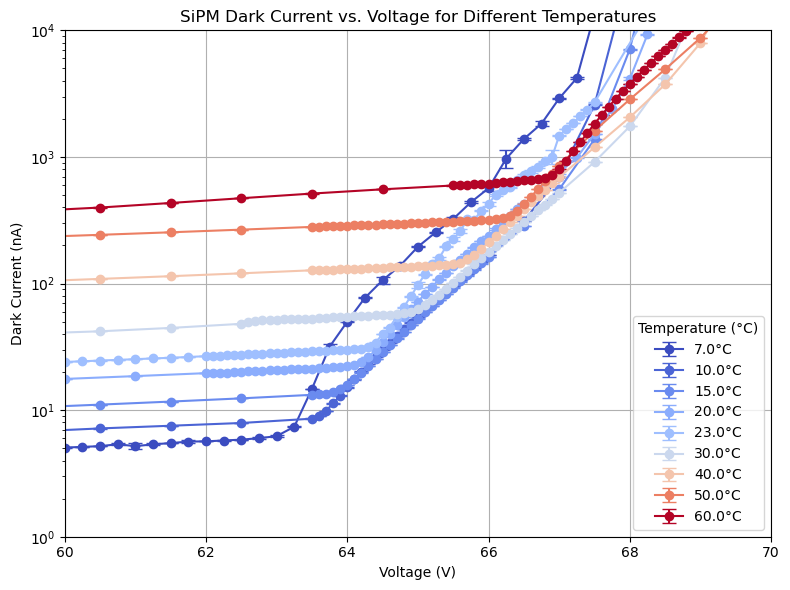

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_iv_curves(folder="IV_data"):
    plt.figure(figsize=(8, 6))
    plt.yscale('log')

    # Gather all CSV files with temperatures
    files_with_temps = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith(".csv"):
            try:
                temp = float(filename.split("_")[-1].replace("C.csv", "").replace(".csv", ""))
                files_with_temps.append((temp, filename))
            except ValueError:
                continue  # skip files without proper temp format

    # Sort files by temperature
    files_with_temps.sort(key=lambda x: x[0])
    temps = [ft[0] for ft in files_with_temps]

    # Normalize temps to 0–1 range for color mapping
    norm = mcolors.Normalize(vmin=min(temps), vmax=max(temps))
    cmap = cm.get_cmap("coolwarm")  # Blue (cold) to red (hot)

    for temp, filename in files_with_temps:
        data = np.loadtxt(os.path.join(folder, filename), delimiter=",", skiprows=1)
        voltages, currents, errors = data[:, 0], data[:, 1], data[:, 2]

        color = cmap(norm(temp))
        plt.errorbar(voltages, np.array(currents) * 1e9, yerr=np.array(errors) * 1e9,
                     fmt='o-', capsize=5, capthick=1, color=color, label=f"{temp:.1f}°C")

    plt.xlabel("Voltage (V)")
    plt.xlim(60, 70)
    plt.ylim(1, 1e4)
    plt.ylabel("Dark Current (nA)")
    plt.title("SiPM Dark Current vs. Voltage for Different Temperatures")
    plt.legend(title="Temperature (°C)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_iv_curves()


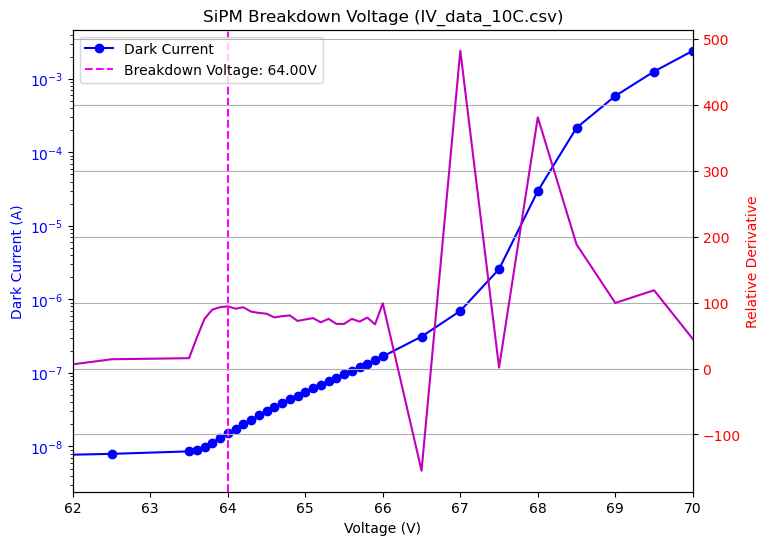

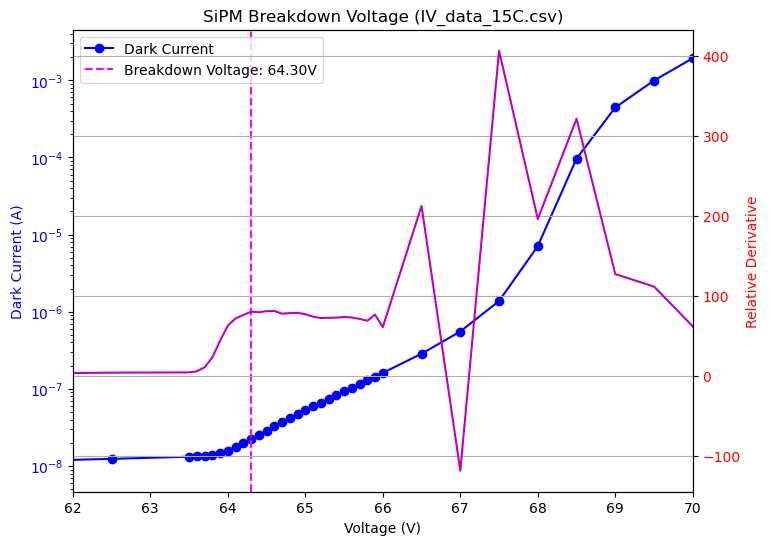

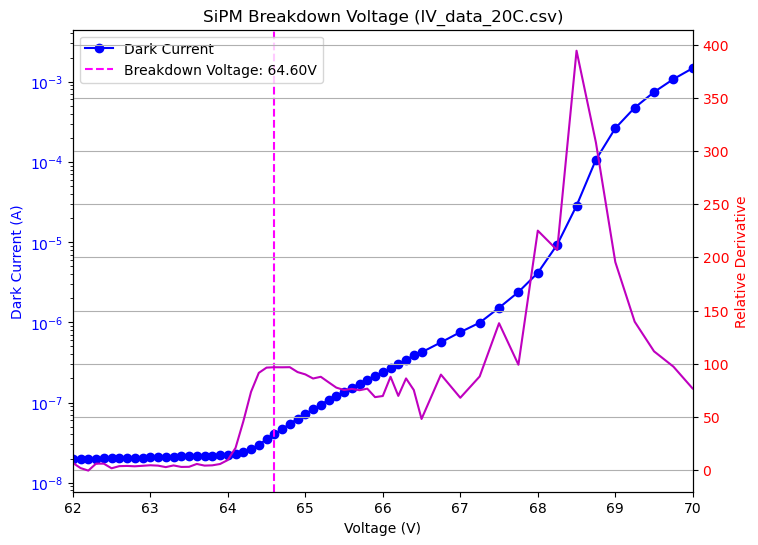

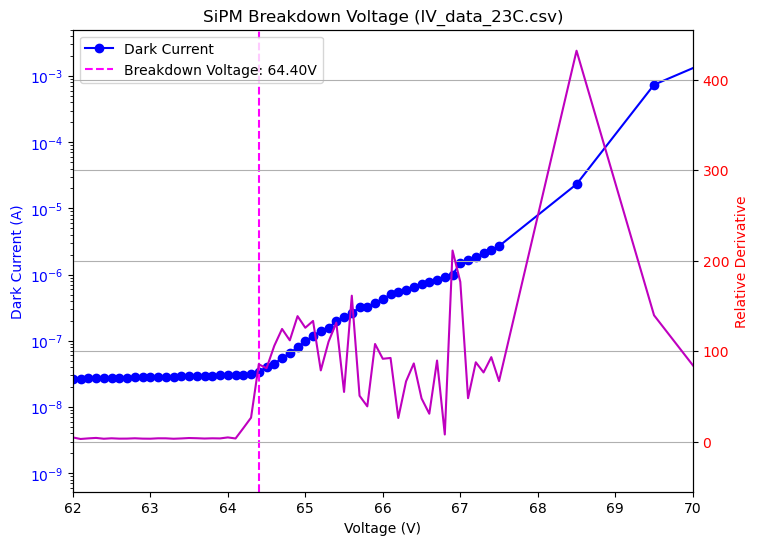

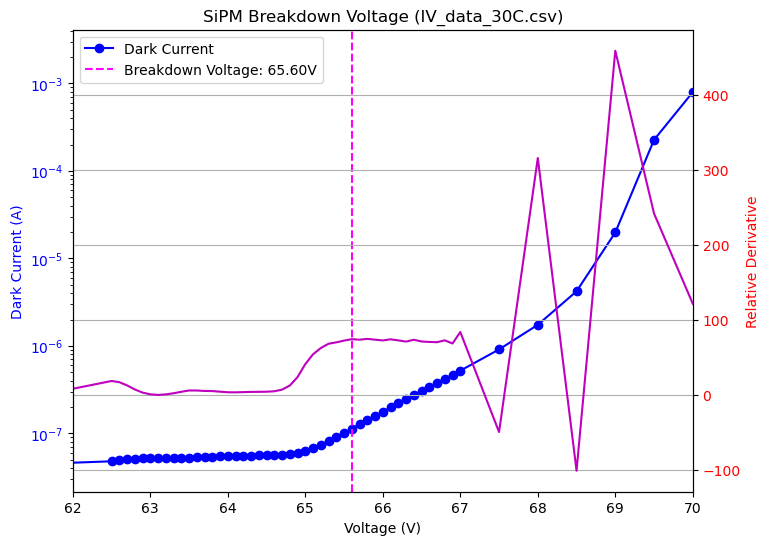

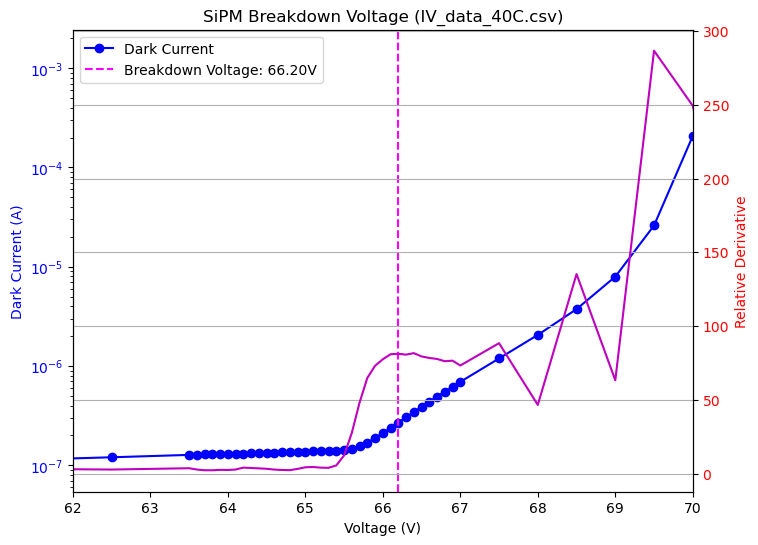

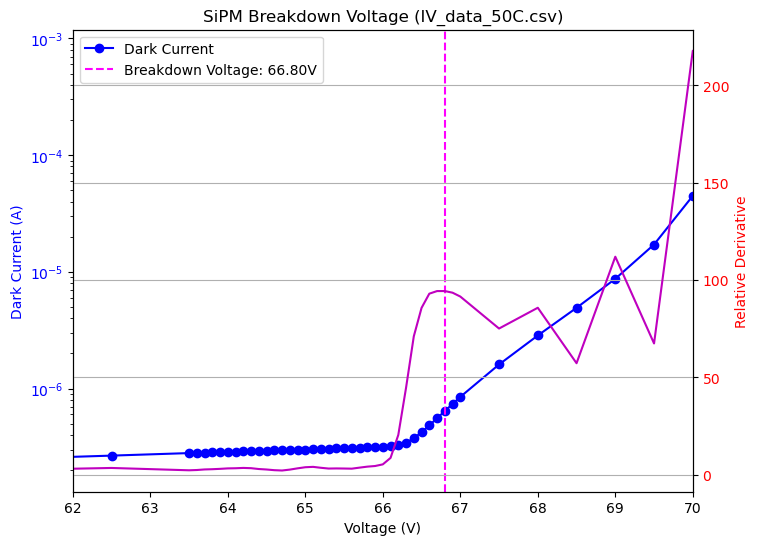

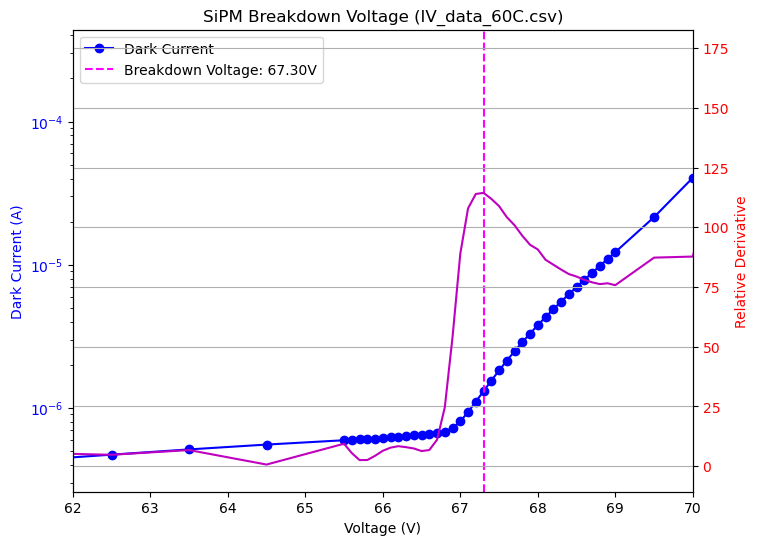

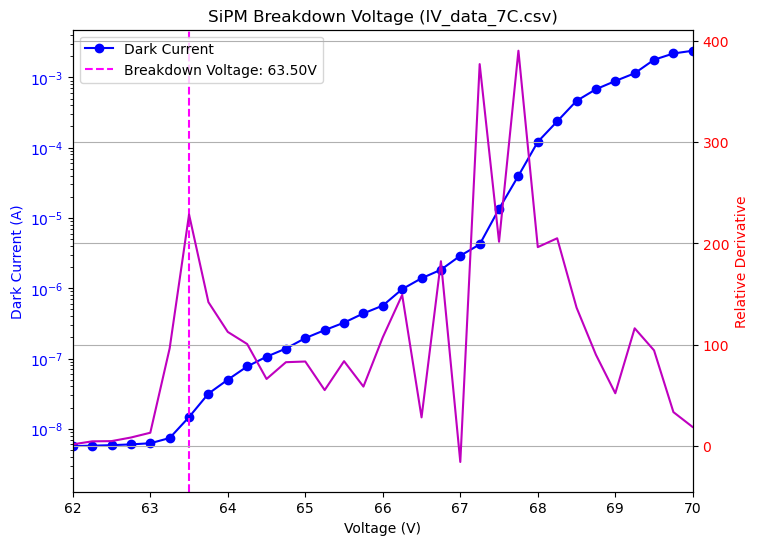


Breakdown Voltages for Each File:
IV_data_10C.csv: 64.00 V
IV_data_15C.csv: 64.30 V
IV_data_20C.csv: 64.60 V
IV_data_23C.csv: 64.40 V
IV_data_30C.csv: 65.60 V
IV_data_40C.csv: 66.20 V
IV_data_50C.csv: 66.80 V
IV_data_60C.csv: 67.30 V
IV_data_7C.csv: 63.50 V


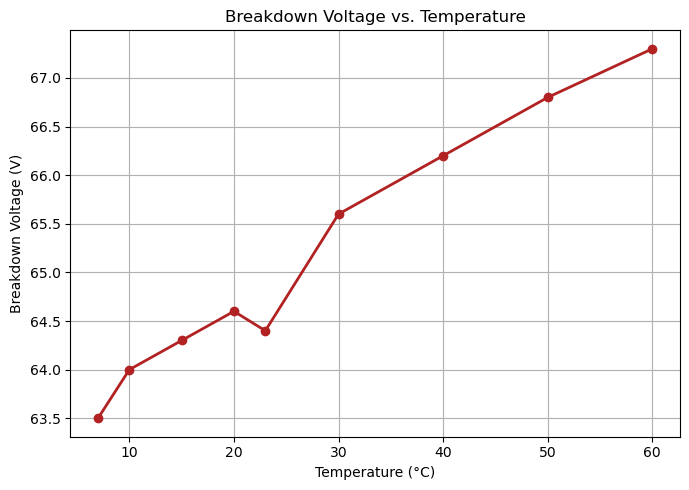

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks
def find_breakdown_voltage(filename, plot_range=2, threshold=90, max_voltage=68, min_voltage = 62):
    """Find the first local max of the relative derivative under 68V and over a threshold."""
    data = pd.read_csv(os.path.join("IV_data", filename))

    voltages = data["Voltage (V)"].values
    currents = np.abs(data["Avg Current (A)"].values)

    # Spline interpolation
    spline = UnivariateSpline(voltages, currents, s=0, k=4)
    dI_dV = spline.derivative()(voltages)
    relative_derivative = (dI_dV / currents) * voltages

    # Focus on voltages under max_voltage
    valid_indices = (voltages > min_voltage) & (voltages < max_voltage)
    rel_deriv = relative_derivative[valid_indices]
    v_filtered = voltages[valid_indices]

    # Find peaks in the relative derivative
    peaks, _ = find_peaks(rel_deriv, height=60)

    breakdown_voltage = None
    if peaks.size > 0:
        breakdown_voltage = v_filtered[peaks[0]]  # First peak below 68V

    if breakdown_voltage is None:
        print(f"Warning: No valid breakdown voltage found in {filename}")
        return filename, None

    # Define zoom-in range
    lower_bound = max(voltages[0], breakdown_voltage - plot_range)
    upper_bound = min(voltages[-1], breakdown_voltage + plot_range)
    zoom_indices = (voltages >= lower_bound) & (voltages <= upper_bound)

    # === Plot ===
    fig, ax1 = plt.subplots(figsize=(8, 6))

    ax1.set_xlabel("Voltage (V)")
    ax1.set_ylabel("Dark Current (A)", color="blue")
    ax1.plot(voltages, currents, 'bo-', label="Dark Current")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.set_yscale('log')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Relative Derivative", color="red")
    ax2.plot(voltages, relative_derivative, 'm-', label="Relative Derivative")
    ax2.tick_params(axis='y', labelcolor="red")

    # Mark breakdown voltage
    ax1.axvline(breakdown_voltage, linestyle="--", color="magenta", label=f"Breakdown Voltage: {breakdown_voltage:.2f}V")
    plt.xlim(62, 70)
    plt.title(f"SiPM Breakdown Voltage ({filename})")
    ax1.legend(loc="upper left")
    plt.grid()
    plt.show()

    return filename, breakdown_voltage
# === Process all files in IV_data folder ===
iv_folder = "IV_data"
breakdown_voltages = []

for file in sorted(os.listdir(iv_folder)):
    if file.endswith(".csv"):
        filename, breakdown_voltage = find_breakdown_voltage(file)
        breakdown_voltages.append((filename, breakdown_voltage))
temps = []
v_br = []
# === Print Results ===
print("\nBreakdown Voltages for Each File:")
for filename, voltage in breakdown_voltages:
    print(f"{filename}: {voltage:.2f} V")
    temp_str = filename.split("_")[2]  # e.g., "20C"
    temp = int(temp_str.replace("C.csv", ""))
    temps.append(temp)
    v_br.append(voltage)

# Sort by temperature
temps, v_br = zip(*sorted(zip(temps, v_br)))

# Plot Breakdown Voltage vs Temperature
plt.figure(figsize=(7, 5))
plt.plot(temps, v_br, 'o-', color='firebrick', linewidth=2, markersize=6)
plt.xlabel("Temperature (°C)")
plt.ylabel("Breakdown Voltage (V)")
plt.title("Breakdown Voltage vs. Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
import mca.mca8000d

ModuleNotFoundError: No module named 'mca.mca8000d'; 'mca' is not a package